## Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import pkg_resources
from google.colab.patches import cv2_imshow
from tkinter import Tcl
import cv2,glob


## Mounting gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the annotaion files

In [ ]:
#Loading the annotations.csv
labels_df = pd.read_csv('/content/drive/MyDrive/annotations.csv', index_col=0)
not_human = []
for index, row in labels_df.iterrows():
  if(row['face not shown/not human'] == 1):
    not_human.append(index)
    labels_df.drop(index, inplace=True)
labels_df.head()

,wrinkles,freakles,glasses,hair_color,hair_top,face not shown/not human
image_name,,,,,,
129.jpg,1,0,0,6,1,0
155.jpg,1,0,0,1,2,0
184.jpg,0,1,0,1,2,0
293.jpg,1,0,0,1,2,0
361.jpg,0,1,0,0,1,0


In [ ]:
#Loading additional annotations
labels_df1 = pd.read_csv('/content/drive/MyDrive/annotations1.csv', index_col=0)
not_human1 = []
for index, row in labels_df1.iterrows():
  if(row['face not shown/not human'] == 1):
    not_human1.append(index)
    labels_df1.drop(index, inplace=True)
labels_df1.head()

,wrinkles,freakles,glasses,hair_color,hair_top,face not shown/not human
image_name,,,,,,
emotionet_3_18.jpg,0,1,0,0,2,0
emotionet_3_241.jpg,0,0,0,4,2,0
emotionet_3_290.jpg,0,0,0,1,2,0
emotionet_3_297.jpg,0,1,0,1,2,0
emotionet_3_319.jpg,0,1,2,1,2,0


## Uploading the images and Pre processing - deecting the face and cropping the image, Resizing them to (200 x 200 x 3) size.


> ### As a part of pre processing, detecting the face and cropping





In [ ]:
items = glob.glob('/content/drive/MyDrive/images/*')

#sorting the images by name so that they have one to one correspondance with annotations.csv
items = Tcl().call('lsort', '-dict', items)

# Removing the non human images
items_sorted = []

# Removing the non human images
for item in items:
  item = item.split('/')[-1]
  if(item not in not_human):
    items_sorted.append('/content/drive/MyDrive/images/' + item)

# Face detection, cropping & resizing the images to 200 x 200
haar_xml = pkg_resources.resource_filename('cv2', 'data/haarcascade_frontalface_default.xml')
all_images = []
for each_image in items_sorted:
  image = cv2.imread(each_image)   
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  face_cascade = cv2.CascadeClassifier(haar_xml)
  faces = face_cascade.detectMultiScale(gray, 1.25, 6)
  if(len(faces) == 1):
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = image[y:y + h, x:x + w]
        faces = cv2.resize(faces, (200, 200))
        all_images.append(faces)
  else:
    faces = cv2.resize(image, (200, 200))
    all_images.append(faces) 

#Adding all converted images to ndarray
images_df = np.array(all_images)
images_df.shape

(1810, 200, 200, 3)

## Uploading the additional images & pre processing

In [ ]:
items1 = glob.glob('/content/drive/MyDrive/images1/*')

#sorting the images by name so that they have one to one correspondance with annotations1.csv
items1 = Tcl().call('lsort', '-dict', items1)

#Removing all non human images
items_sorted1 = []
for item in items1:
  item = item.split('/')[-1]
  if(item not in not_human1):
    items_sorted1.append('/content/drive/MyDrive/images1/' + item)

# Face detection, cropping & resizing the images to 200 x 200
all_images1 = []
for each_image in items_sorted1:
  image = cv2.imread(each_image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  face_cascade = cv2.CascadeClassifier(haar_xml)
  faces = face_cascade.detectMultiScale(gray, 1.25, 6)
  if(len(faces) == 1):
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = image[y:y + h, x:x + w]
        faces = cv2.resize(faces, (200, 200))
        all_images1.append(faces)
  else:
    faces = cv2.resize(image, (200, 200))
    all_images1.append(faces) 

#Adding all converted images to ndarray
images_df1 = np.array(all_images1)
images_df1.shape

(1913, 200, 200, 3)

# Model 1 - Wrinkles

## Combining images & labels

In [ ]:
images_sampling = np.vstack((images_df, images_df1))
images_sampling.shape

(3723, 200, 200, 3)

In [ ]:
df_wrinkles = pd.DataFrame()
df_wrinkles['images'] = all_images
labels = labels_df['wrinkles'].copy()
df_wrinkles['labels'] = labels.values

df_wrinkles1 = pd.DataFrame()
df_wrinkles1['images'] = all_images1
labels1 = labels_df1['wrinkles'].copy()
df_wrinkles1['labels'] = labels1.values

In [ ]:
#Count of classes (0 - no wrinkles, 1 - has wrinkles)
total_counts = df_wrinkles['labels'].value_counts() + df_wrinkles1['labels'].value_counts()
total_counts

0    2544
1    1179
Name: labels, dtype: int64

## Data Balancing - Over Sampling the classes that has less data

In [ ]:
df_no_wrinkles = df_wrinkles[df_wrinkles['labels']==0]
df_yes_wrinkles = df_wrinkles[df_wrinkles['labels']==1]

df_no_wrinkles1 = df_wrinkles1[df_wrinkles1['labels']==0]
df_yes_wrinkles1 = df_wrinkles1[df_wrinkles1['labels']==1]

df_wrinkles_sampling = pd.DataFrame(df_no_wrinkles.append(df_no_wrinkles1))
for i in range(2):
  df_wrinkles_sampling = df_wrinkles_sampling.append(df_yes_wrinkles)
  df_wrinkles_sampling = df_wrinkles_sampling.append(df_yes_wrinkles1)

In [ ]:
#Count of Classes after sampling - data balancing
total_counts_sampling = df_wrinkles_sampling['labels'].value_counts()
total_counts_sampling

0    2544
1    2358
Name: labels, dtype: int64

In [ ]:
X = np.array(df_wrinkles_sampling['images'])
y = np.array(df_wrinkles_sampling['labels'])
a = []
for i in range(len(X)):
  a.append(X[i])
X = np.array(a)
X.shape

(4902, 200, 200, 3)

## Data samples before and after balancing

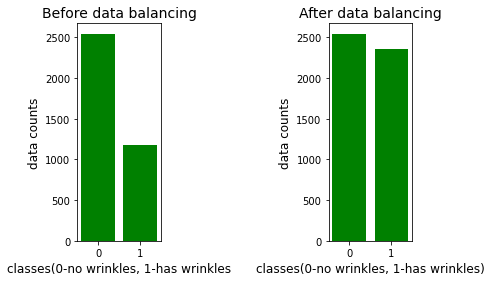

In [ ]:

plt.subplot(1, 2, 1)
plt.bar(total_counts.index,total_counts, align='center',  color = 'green')
#plt.xticks([0, 1])
plt.xlabel('classes(0-no wrinkles, 1-has wrinkles', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('Before data balancing', fontsize=14)
plt.subplots_adjust(wspace = 1.5, hspace = 1.5)

plt.subplot(1, 2, 2)
plt.bar(total_counts_sampling.index,total_counts_sampling, align='center',  color = 'green')
#plt.xticks([0, 1])
plt.xlabel('classes(0-no wrinkles, 1-has wrinkles)', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('After data balancing', fontsize=14)
plt.subplots_adjust(wspace = 2, hspace = 2)

plt.show()

## Label Encoding

In [ ]:
y_encode = LabelEncoder()
y = y_encode.fit_transform(y)

## Split train and test images



In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=120, stratify=y)

In [ ]:
print(f'Shape of the training data: {train_images.shape}')
print(f'Shape of the training target: {train_labels.shape}')
print(f'Shape of the test data: {test_images.shape}')
print(f'Shape of the test target: {test_labels.shape}')

Shape of the training data: (3921, 200, 200, 3)
Shape of the training target: (3921,)
Shape of the test data: (981, 200, 200, 3)
Shape of the test target: (981,)


In [ ]:
np.unique(train_labels, return_counts=True)

(array([0, 1]), array([2035, 1886]))

In [ ]:
np.unique(test_labels, return_counts=True)

(array([0, 1]), array([509, 472]))

## Normalising of images

In [ ]:
# Normalizing
train_images, test_images = train_images / 255.0, test_images / 255.0

## DenseNet Pretrained model

In [ ]:
#Data Augmentaion for training images
data_augmentation = keras.Sequential(
    [  
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation([0.1,0.2]),
        preprocessing.RandomContrast([0.1, 0.5]),
        preprocessing.RandomZoom(0.1),
        preprocessing.RandomZoom(0.2)
    ]
)

input_shape = (200, 200, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)

model1 = keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=input_shape)(x)

# adding output layer
flat1 = layers.Flatten()(model1)
Dropout1 = layers.Dropout(0.2)(flat1)
output = layers.Dense(2, activation='softmax')(flat1)

# define new model
model1 = Model(inputs=inputs, outputs=output)

model1.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model1.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential_21 (Sequential)   (None, 200, 200, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
flatten_21 (Flatten)         (None, 59904)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 119810    
Total params: 12,762,690
Trainable params: 12,604,290
Non-trainable params: 158,400
_________________________________________________________________


## Training the Model

Epoch 1/5
62/62 [==============================] - 39s 414ms/step - loss: 0.9537 - accuracy: 0.6526 - val_loss: 1.0502 - val_accuracy: 0.5790
Epoch 2/5
62/62 [==============================] - 23s 376ms/step - loss: 0.3562 - accuracy: 0.8507 - val_loss: 0.5549 - val_accuracy: 0.7492
Epoch 3/5
62/62 [==============================] - 23s 376ms/step - loss: 0.2587 - accuracy: 0.8965 - val_loss: 0.5227 - val_accuracy: 0.7706
Epoch 4/5
62/62 [==============================] - 23s 376ms/step - loss: 0.2439 - accuracy: 0.9072 - val_loss: 0.5515 - val_accuracy: 0.7625
Epoch 5/5
62/62 [==============================] - 23s 376ms/step - loss: 0.1527 - accuracy: 0.9406 - val_loss: 0.5233 - val_accuracy: 0.7920
31/31 - 2s - loss: 0.5233 - accuracy: 0.7920


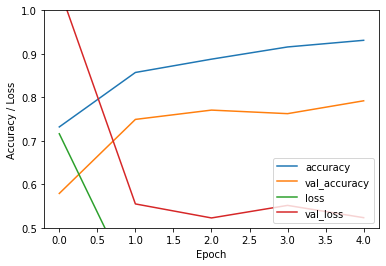

In [ ]:
# Training

history = model1.fit(train_images, train_labels, epochs=5, batch_size=64,
                    validation_data=(test_images, test_labels))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model1.evaluate(test_images,  test_labels, verbose=2)

## Saving the Model

In [ ]:
model1.save_weights('/content/drive/MyDrive/model_wrinkles_weights1', save_format = 'h5')
model1.save('/content/drive/MyDrive/model_wrinkles1', save_format='h5')

## checking the prediction on validation dataset

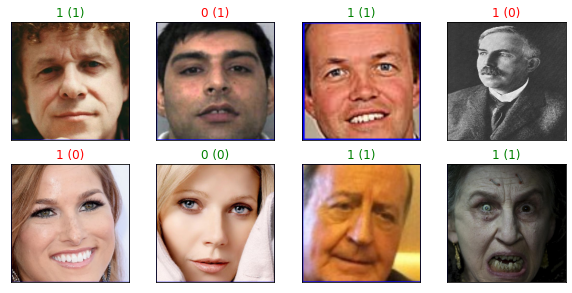

In [ ]:
import pdb
y_hat = model1.predict(test_images)

# Plot a random sample of 8 test images, their predicted labels and actual labels
figure = plt.figure(figsize=(10, 10))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=8, replace=False)):
    ax = figure.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(predict_index, 
                                  true_index),
                                  color=("green" if predict_index == true_index else "red"))

## Performance/Evaluation Metrics

In [ ]:
# Calculating metrics

y_hat = model1.predict(test_images)
y_pred = np.argmax(y_hat, axis=1)

print('\n Classification Report: \n',classification_report(test_labels, y_pred))
print('\n Accuracy Score: {:.4f}'.format(accuracy_score(test_labels, y_pred)))
print('\n Precision Score: {:.4f}'.format(precision_score(test_labels, y_pred , average="macro")))
print('\n Recall Score: {:.4f}'.format(recall_score(test_labels, y_pred , average="macro")))
print('\n f1_score: {:.4f}'.format(f1_score(test_labels, y_pred , average="macro")))
print('\n Confusion Matrix \n {}' .format(confusion_matrix(test_labels, y_pred )))



 Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       509
           1       0.85      0.69      0.76       472

    accuracy                           0.79       981
   macro avg       0.80      0.79      0.79       981
weighted avg       0.80      0.79      0.79       981


 Accuracy Score: 0.7920

 Precision Score: 0.8022

 Recall Score: 0.7884

 f1_score: 0.7886

 Confusion Matrix 
 [[451  58]
 [146 326]]


# Model 2 - Freakles

### Combining images & labels

In [ ]:
df_freakles = pd.DataFrame()
df_freakles['images'] = all_images
labels = labels_df['freakles'].copy()
df_freakles['labels'] = labels.values

df_freakles1 = pd.DataFrame()
df_freakles1['images'] = all_images1
labels1 = labels_df1['wrinkles'].copy()
df_freakles1['labels'] = labels1.values

In [ ]:
total_counts = df_freakles['labels'].value_counts() + df_freakles1['labels'].value_counts()
total_counts

0    3008
1     715
Name: labels, dtype: int64

## Data Balancing - Over Sampling the classes that has less data

In [ ]:
df_no_freakles = df_freakles[df_freakles['labels']==0]
df_yes_freakles = df_freakles[df_freakles['labels']==1]

df_no_freakles1 = df_freakles1[df_freakles1['labels']==0]
df_yes_freakles1 = df_freakles1[df_freakles1['labels']==1]

df_freakles_sampling = pd.DataFrame((df_no_freakles.append(df_no_freakles1)).iloc[:2200])
for i in range(3):
  df_freakles_sampling = df_freakles_sampling.append(df_yes_freakles)
  df_freakles_sampling = df_freakles_sampling.append(df_yes_freakles1)

In [ ]:
total_counts_sampling = df_freakles_sampling['labels'].value_counts()
total_counts_sampling

0    2200
1    2145
Name: labels, dtype: int64

In [ ]:
X = np.array(df_freakles_sampling['images'])
y = np.array(df_freakles_sampling['labels'])
a = []
for i in range(len(X)):
  a.append(X[i])
X = np.array(a)
X.shape

(4345, 200, 200, 3)

## Data samples before and after balancing

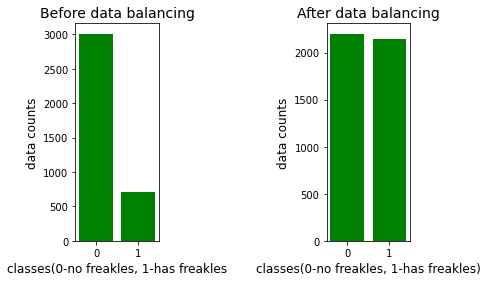

In [ ]:
plt.subplot(1, 2, 1)
plt.bar(total_counts.index,total_counts, align='center',  color = 'green')
#plt.xticks([0, 1])
plt.xlabel('classes(0-no freakles, 1-has freakles', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('Before data balancing', fontsize=14)
plt.subplots_adjust(wspace = 1.5, hspace = 1.5)

plt.subplot(1, 2, 2)
plt.bar(total_counts_sampling.index,total_counts_sampling, align='center',  color = 'green')
#plt.xticks([0, 1])
plt.xlabel('classes(0-no freakles, 1-has freakles)', fontsize=12)
plt.ylabel('data counts', fontsize=12)
plt.title('After data balancing', fontsize=14)
plt.subplots_adjust(wspace = 2, hspace = 2)

plt.show()

## Label Encoding

In [ ]:
y_encode = LabelEncoder()
y_encode.fit(y)
y = y_encode.transform(y)

## Split train and test images



In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

In [ ]:
print(f'Shape of the training data: {train_images.shape}')
print(f'Shape of the training target: {train_labels.shape}')
print(f'Shape of the test data: {test_images.shape}')
print(f'Shape of the test target: {test_labels.shape}')

Shape of the training data: (3476, 200, 200, 3)
Shape of the training target: (3476,)
Shape of the test data: (869, 200, 200, 3)
Shape of the test target: (869,)


In [ ]:
np.unique(train_labels, return_counts=True)

(array([0, 1]), array([1760, 1716]))

In [ ]:
np.unique(test_labels, return_counts=True)

(array([0, 1]), array([440, 429]))

## Normalising of images

In [ ]:
# Normalizing
train_images, test_images = train_images / 255.0, test_images / 255.0

## DenseNet pretrained model

In [ ]:
#Data Augmentation
data_augmentation = keras.Sequential(
    [  
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1)
    ]
)

input_shape = (200, 200, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)

model2 = keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=input_shape)(x)

# adding output layer
flat1 = layers.Flatten()(model2)
output = layers.Dense(2, activation='softmax')(flat1)


# define new model
model2 = Model(inputs=inputs, outputs=output)

model2.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model2.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential_43 (Sequential)   (None, 200, 200, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
flatten_43 (Flatten)         (None, 59904)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 119810    
Total params: 12,762,690
Trainable params: 12,604,290
Non-trainable params: 158,400
_________________________________________________________________


## Training the Model

Epoch 1/4
55/55 [==============================] - 42s 431ms/step - loss: 0.8878 - accuracy: 0.6126 - val_loss: 0.7895 - val_accuracy: 0.6398
Epoch 2/4
55/55 [==============================] - 21s 376ms/step - loss: 0.5305 - accuracy: 0.7831 - val_loss: 0.5998 - val_accuracy: 0.7399
Epoch 3/4
55/55 [==============================] - 21s 376ms/step - loss: 0.3480 - accuracy: 0.8507 - val_loss: 0.5751 - val_accuracy: 0.7825
Epoch 4/4
55/55 [==============================] - 21s 376ms/step - loss: 0.3041 - accuracy: 0.8782 - val_loss: 0.5066 - val_accuracy: 0.7917
28/28 - 2s - loss: 0.5066 - accuracy: 0.7917
0.791714608669281


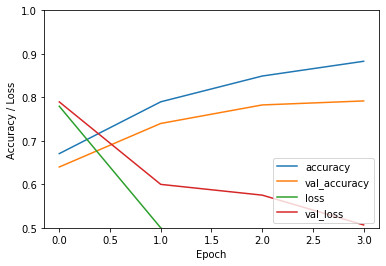

In [ ]:
# Training

history = model2.fit(train_images, train_labels, epochs=4, batch_size=64,
                    validation_data=(test_images, test_labels))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

## Saving the model

In [ ]:
model2.save_weights('/content/drive/MyDrive/model_freakles_weights4', save_format = 'h5')
model2.save('/content/drive/MyDrive/model_freakles4', save_format='h5')

## checking the prediction on validation dataset

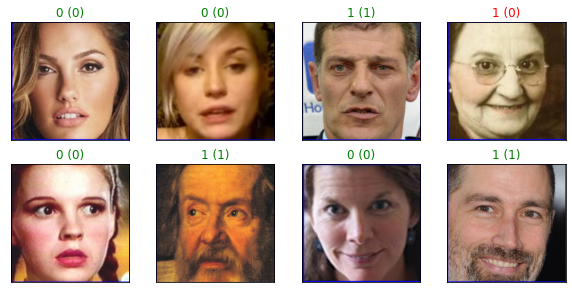

In [ ]:
import pdb
y_hat = model2.predict(test_images)

# Plot a random sample of 8 test images, their predicted labels and actual labels
figure = plt.figure(figsize=(10, 10))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=8, replace=False)):
    ax = figure.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(predict_index, 
                                  true_index),
                                  color=("green" if predict_index == true_index else "red"))

## Evaluation Metrics

In [ ]:
# Calculating metrics

y_hat = model2.predict(test_images)
y_pred = np.argmax(y_hat, axis=1)

print('\n Classification Report:\n',classification_report(test_labels, y_pred))
print('\n Accuracy Score: {:.4f}'.format(accuracy_score(test_labels, y_pred)))
print('\n Precision Score: {:.4f}'.format(precision_score(test_labels, y_pred , average="macro")))
print('\n Recall Score: {:.4f}'.format(recall_score(test_labels, y_pred , average="macro")))
print('\n f1_score: {:.4f}'.format(f1_score(test_labels, y_pred , average="macro")))
print('\n Confusion Matrix: \n {}' .format(confusion_matrix(test_labels, y_pred )))



 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       440
           1       0.81      0.75      0.78       429

    accuracy                           0.79       869
   macro avg       0.79      0.79      0.79       869
weighted avg       0.79      0.79      0.79       869


 Accuracy Score: 0.7917

 Precision Score: 0.7933

 Recall Score: 0.7912

 f1_score: 0.7912

 Confusion Matrix: 
 [[365  75]
 [106 323]]
